In [28]:
import torch
from scipy.optimize import linear_sum_assignment

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDetermineBonds

from flowmm.rfm.manifolds.flat_torus import FlatTorus01
from rfm_docking.utils import fast_wrap_coords_edge_based
from rfm_docking.featurization import get_bond_edges
from diffcsp.script_utils import chemical_symbols

def kabsch_torch(P, Q):
    """
    From https://hunterheidenreich.com/posts/kabsch_algorithm/
    Computes the optimal rotation and translation to align two sets of points (P -> Q),
    and their RMSD.
    :param P: A Nx3 matrix of points
    :param Q: A Nx3 matrix of points
    :return: A tuple containing the optimal rotation matrix, the optimal
             translation vector, and the RMSD.
    """
    assert P.shape == Q.shape, "Matrix dimensions must match"

    # Compute centroids
    centroid_P = torch.mean(P, dim=0)
    centroid_Q = torch.mean(Q, dim=0)

    # Optimal translation
    t = centroid_Q - centroid_P

    # Center the points
    p = P - centroid_P
    q = Q - centroid_Q

    # Compute the covariance matrix
    H = torch.matmul(p.transpose(0, 1), q)

    # SVD
    U, S, Vt = torch.linalg.svd(H)

    # Validate right-handed coordinate system
    if torch.det(torch.matmul(Vt.transpose(0, 1), U.transpose(0, 1))) < 0.0:
        Vt[:, -1] *= -1.0

    # Optimal rotation
    R = torch.matmul(Vt.transpose(0, 1), U.transpose(0, 1))

    # RMSD
    rmsd = torch.sqrt(torch.sum(torch.square(torch.matmul(p, R.transpose(0, 1)) - q)) / P.shape[0])

    return R, t, rmsd

def compare_distance_matrix(osda_pred, osda_target, loading, lattice):
    # split the osda_pred and osda_target with loading
    osda_preds_split = torch.split(osda_pred, osda_pred.shape[0] // loading)

    pred_d_vectors = [
        FlatTorus01.logmap(p[:, None, :], p[None, :, :]) for p in osda_preds_split
    ]
    pred_d_vectors = torch.stack(pred_d_vectors)

    # frac to cartesian
    pred_d_vectors = torch.matmul(pred_d_vectors, lattice.T)
    pred_d_matrices = (pred_d_vectors**2).sum(-1).sqrt()

    osda_targets_split = torch.split(osda_target, osda_target.shape[0] // loading)

    osda_target_d_matrices = [
        FlatTorus01.logmap(t[:, None, :], t[None, :, :]) for t in osda_targets_split
    ]
    osda_target_d_vectors = torch.stack(osda_target_d_matrices)

    # frac to cartesian
    osda_target_d_vectors = torch.matmul(osda_target_d_vectors, lattice.T)
    osda_target_d_matrices = (osda_target_d_vectors**2).sum(-1).sqrt()

    cost_vectors = pred_d_matrices[None, :, :] - osda_target_d_matrices[:, None, :]

    # take the norm in the last two dimensions
    cost_matrix = torch.norm(cost_vectors, dim=(-2, -1))
    cost_matrix = cost_matrix.numpy()

    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # displacement on molecule level
    total_displacement = cost_matrix[row_ind, col_ind].sum()
    mean_mol_displacement = cost_matrix[row_ind, col_ind].mean()
    max_mol_displacement = cost_matrix[row_ind, col_ind].max()
    min_mol_displacement = cost_matrix[row_ind, col_ind].min()

    # displacement on atom level
    cost = torch.abs(pred_d_matrices - osda_target_d_matrices[col_ind])
    # remove diagonal
    diag_indices = torch.arange(cost.shape[-1])
    diag_mask = torch.ones_like(cost, dtype=bool)
    diag_mask[:, diag_indices, diag_indices] = 0

    mean_atom_displacement = cost[diag_mask].mean().item()
    max_atom_displacement = cost[diag_mask].max().item()
    min_atom_displacement = cost[diag_mask].min().item()

    displacements = {
        "total_displacement": total_displacement,
        "mean_total_displacement": mean_mol_displacement,
        "max_total_displacement": max_mol_displacement,
        "min_total_displacement": min_mol_displacement,
        "mean_atom_displacement": mean_atom_displacement,
        "max_atom_displacement": max_atom_displacement,
        "min_atom_displacement": min_atom_displacement,
    }

    return displacements

def check_rmsd(osda_pred_frac, osda_target_frac, lattice, loading, smiles):

    osda_target_cart = torch.matmul(osda_target_frac, lattice.T)
    osda_target_split = torch.split(osda_target_cart, osda_target_cart.shape[0] // loading)
    osda_pred_cart = torch.matmul(osda_pred_frac, lattice.T)
    osda_pred_split = torch.split(osda_pred_cart, osda_pred_cart.shape[0] // loading)

    # get edges from smiles
    mol_edges, _ = get_bond_edges(Chem.MolFromSmiles(smiles))

    pred = [fast_wrap_coords_edge_based(i, lattice, mol_edges, return_cart=True) for i in osda_pred_split]
    target = [fast_wrap_coords_edge_based(i, lattice, mol_edges, return_cart=True) for i in osda_target_split]

    min_rmsds = []
    for idx_i, i in enumerate(pred):
        rmsds = []
        for idx_j, j in enumerate(target):
            R, t, rmsd = kabsch_torch(i, j)
            rmsds.append(rmsd)
        min_rmsd = min(rmsds)
        min_rmsds.append(min_rmsd)


    rmsd = torch.tensor(min_rmsds).mean().cpu().item()
    return rmsd

# TODO atom is clashed once--> clash. do not count multiple times
def check_zeolite_osda_clash(zeolite_pos, osda_pos, loading, lattice, distance_cutoff=2.0):
    """
    Check clashes between osda and zeolite. Distance cutoff 1.5A taken from VOID + 1.1A = 2.6A for C-H bond.
    """
    distance_vectors = FlatTorus01.logmap(zeolite_pos[:, None, :], osda_pos[None, :, :])
    distance_vectors = torch.matmul(distance_vectors, lattice.T)
    distance_matrix = (distance_vectors**2).sum(-1).sqrt()

    is_clash = distance_matrix < distance_cutoff

    is_clash_atomwise = torch.any(is_clash, dim=-1)
    
    is_clash_split = torch.split(is_clash, is_clash.shape[0] // loading)
    is_clash_molwise = [torch.any(i).to(torch.int32).item() for i in is_clash_split]
    num_clash_molwise = sum(is_clash_molwise)

    num_clashes_atom = (is_clash_atomwise).sum().item() 

    return num_clash_molwise


def check_osda_osda_clash(osda_pos_frac, loading, lattice, distance_cutoff=2.2):
    """distance cutoff 2 * 1.1A = 2.2A for C-H bond."""
    if loading==1:
        # no clash possible
        return None
    atoms_per_mol = osda_pos_frac.shape[0] // loading

    distance_vector_frac = FlatTorus01.logmap(
        osda_pos_frac[:, None, :], osda_pos_frac[None, :, :]
    )

    # frac to cartesian
    distance_vector_cart = torch.matmul(distance_vector_frac, lattice.T)
    distance_matrix = (distance_vector_cart**2).sum(-1).sqrt()

    mask = torch.ones_like(distance_matrix, dtype=bool)
    mask = mask.triu(diagonal=1)

    # mask out intramolecular distances
    for i in range(loading):
        start = i * atoms_per_mol
        end = (i + 1) * atoms_per_mol
        mask[start:end, start:end] = False

    is_clash = distance_matrix < distance_cutoff
    is_clash = torch.logical_and(is_clash, mask)
    is_clash = torch.any(is_clash, dim=-1)

    num_clashes_atomwise = (is_clash).sum().item()

    is_clash_split = torch.split(is_clash, is_clash.shape[0] // loading)
    num_clashes_molwise = [torch.any(i).to(torch.int32).item() for i in is_clash_split]
    num_clashes_molwise = sum(num_clashes_molwise)
  
    return num_clashes_molwise

def get_average_path_length(com_traj_frac, osda_traj_frac, loading, lattice):
    # calculate path length based on frac coordinates
    len_traj = len(osda_traj_frac)

    path_len_com = 0
    if com_traj_frac is not None:
        path_len_cart = torch.zeros((com_traj_frac[0].shape[0], ))
        for i in range(1, len_traj):
            path_vector_i = FlatTorus01.logmap(com_traj_frac[i - 1], com_traj_frac[i])
            path_vector_cart = torch.matmul(path_vector_i.to(device=lattice.device), lattice.T)
            len_path_vector = (path_vector_cart**2).sum(-1).sqrt()
            path_len_cart += len_path_vector
        path_len_com = path_len_cart.mean().cpu().item()
    
    path_len_cart = torch.zeros((osda_traj_frac[0].shape[0], ))
    for i in range(1, len_traj):
        path_vector_i = FlatTorus01.logmap(osda_traj_frac[i - 1], osda_traj_frac[i])
        path_vector_cart = torch.matmul(path_vector_i.to(device=lattice.device), lattice.T)
        len_path_vector = (path_vector_cart**2).sum(-1).sqrt()
        path_len_cart += len_path_vector

    path_len_osda = path_len_cart.mean().cpu().item()

    total_path_len = path_len_com + path_len_osda
    return total_path_len
            

In [29]:
import os
from diffcsp.common.data_utils import (
    lattice_params_to_matrix_torch,
)
def evaluate(dir):
    # get all files in dir that are .pt files
    files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith(".pt")]

    all_stats = {}

    for file in files:
        # load the files
        data = torch.load(file)

        smiles = data["smiles"]
        crystal_id = data["crystal_id"]

        osda = data["osda"]
        osda_atom_types = osda["atom_types"]
        osda_target_frac = osda["target_coords"].cpu()
        osda_pred_frac = osda["frac_coords"][-1].cpu()

        zeolite = data["zeolite"]
        zeolite_pos = zeolite["target_coords"].cpu()

        lattice = data["lattices"]
        lattice = lattice_params_to_matrix_torch(
            lattice[:3].unsqueeze(0), lattice[3:].unsqueeze(0)
        )
        lattice = lattice.squeeze().to(device=osda_pred_frac.device)

        loading = data["loading"].cpu().item()

        # is_wrong_mol = check_correct_molecule(osda_pred_frac, osda_atom_types, smiles, loading, lattice)
        rmsd = check_rmsd(osda_pred_frac, osda_target_frac, lattice, loading, smiles)

        # check the clash between osda and zeolite for different cutoffs
        osda_zeolite_clashes150 = check_zeolite_osda_clash(zeolite_pos, osda_pred_frac, loading, lattice,distance_cutoff=1.5)
        osda_zeolite_clashes175 = check_zeolite_osda_clash(zeolite_pos, osda_pred_frac, loading, lattice,distance_cutoff=1.75)
        osda_zeolite_clashes200 = check_zeolite_osda_clash(zeolite_pos, osda_pred_frac, loading, lattice,distance_cutoff=2.0)

        # check the clash between osda molecules for different cutoffs
        osda_osda_clashes175 = check_osda_osda_clash(osda_pred_frac, loading, lattice, distance_cutoff=1.75)
        osda_osda_clashes200 = check_osda_osda_clash(osda_pred_frac, loading, lattice, distance_cutoff=2.0)
        osda_osda_clashes225 = check_osda_osda_clash(osda_pred_frac, loading, lattice, distance_cutoff=2.25)

        if "com" in data.keys():
            avg_path_length = get_average_path_length(data["com"]["frac_coords"],osda["frac_coords"], loading, lattice)
        else:
            avg_path_length = get_average_path_length(None, osda["frac_coords"], loading, lattice)

        all_stats[crystal_id] = {
            "loading": loading,
            "rmsd": rmsd,
            "osda_zeolite_clashes150": osda_zeolite_clashes150,
            "osda_zeolite_clashes175": osda_zeolite_clashes175,
            "osda_zeolite_clashes200": osda_zeolite_clashes200,
            "osda_osda_clashes175": osda_osda_clashes175,
            "osda_osda_clashes200": osda_osda_clashes200,
            "osda_osda_clashes225": osda_osda_clashes225,
            "avg_path_length": avg_path_length,
            "time_per_sample": data["time_per_sample"].cpu().item()
        }
    return all_stats    

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_countplot(df_stat_list, samplings, df_key, x_label):
    all_stats = {i: j[df_key] for i, j in zip(samplings, df_stat_list)}

    """data_for_plot = []
    for key, values in all_stats.items():
        for value in values:
            # Create a bin category for each value
            bin_category = value if value <= 10 else '>10'
            data_for_plot.append({'List': key, 'OSDA-OSDA clashes': bin_category})

    df = pd.DataFrame(data_for_plot)
    df['OSDA-OSDA clashes'] = pd.Categorical(df['OSDA-OSDA clashes'], categories=list(range(0, 11)) + ['>10'], ordered=True)
    """

    data_for_plot = []
    for key, values in all_stats.items():
        for value in values:
            # Create a bin category for each value
            data_for_plot.append({'List': key, x_label: value})

    df = pd.DataFrame(data_for_plot)

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df,
        x=x_label,
        hue='List',
        palette='viridis',
        dodge=True  # Ensures bars are placed next to each other
    )
    plt.legend(title='Category')
    plt.show()

def make_boxplot(df_stat_list, samplings, df_key):
    all_stats = {i: j[df_key] for i, j in zip(samplings, df_stat_list)}

    all_stats_df = pd.DataFrame(all_stats)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.boxplot(data=all_stats_df, ax=ax, palette='viridis')
    plt.show()

# 2k epochs model

## We use D=docking, DD=dual_docking, UG=uniform_then_gaussian, UC=uniform_then_conformer, VG, VC

In [31]:
# do not run cell anymore
## %%script false --no-raise-error

test_sets = ["test_2", "test_3"] #"test_1",
samplings = ["uniform_then_gaussian"]# ", uniform_then_conformer", "voronoi_then_gaussian", "voronoi_then_conformer"]
ots = ["OT"]# ["noOT", "OT"]

for test_set in test_sets:
    for sampling in samplings:
        for ot in ots:
            path = f"/home/malte/flowmm/models/Docking/{sampling}/{ot}/results_model3k5/{test_set}/"

            dirs = os.listdir(path)
            all_dfs = []
            for seed_dir in dirs:
                seed_dir_i = os.path.join(path, seed_dir)
                stats = evaluate(seed_dir_i)
                df = pd.DataFrame(stats).T
                df["seed"] = seed_dir
                all_dfs.append(df)

            merged = pd.concat(all_dfs)

            csv_path = os.path.join(path, "stats.csv")
            merged.to_csv(f"{csv_path}")

UsageError: Line magic function `%%script` not found.


In [32]:
# do not run cell anymore
%%script false --no-raise-error

test_sets = ["test_1", "test_2", "test_3"]
samplings = ["uniform", "voronoi"]
ots = ["noOT", "OT"]

for test_set in test_sets:
    for sampling in samplings:
        for ot in ots:
            path = f"/home/malte/flowmm/models/DualDocking/{sampling}/{ot}/results_model3k5/{test_set}/"

            dirs = os.listdir(path)
            all_dfs = []
            for seed_dir in dirs:
                seed_dir_i = os.path.join(path, seed_dir)
                stats = evaluate(seed_dir_i)
                df = pd.DataFrame(stats).T
                df["seed"] = seed_dir
                all_dfs.append(df)

            merged = pd.concat(all_dfs)

            csv_path = os.path.join(path, "stats.csv")
            merged.to_csv(f"{csv_path}")

UsageError: Line magic function `%%script` not found.


In [23]:
dummy_data = pd.concat(all_dfs)
print("Data size: ", len(dummy_data))
low_rmsd_data = dummy_data[dummy_data["rmsd"] < 2]
print("Data with RMSD < 2: ", len(low_rmsd_data))

# loading==1 does not have osda_osda_clashes
low_rmsd_loading_one = low_rmsd_data[low_rmsd_data["loading"] == 1]
low_rmsd_no_osda_clash = low_rmsd_data[low_rmsd_data["osda_osda_clashes225"] == 0]

low_rmsd_no_osda_clash = pd.concat([low_rmsd_no_osda_clash, low_rmsd_loading_one])

print("Of that, data with no OSDA-OSDA clashes: ", len(low_rmsd_no_osda_clash))

low_rmsd_no_osda_clash_no_zeolite_clash = low_rmsd_no_osda_clash[low_rmsd_no_osda_clash["osda_zeolite_clashes200"] ==0]

print("Of that, data with no OSDA-zeolite clashes: ", len(low_rmsd_no_osda_clash_no_zeolite_clash))
low_rmsd_no_osda_clash_no_zeolite_clash

Data size:  2540
Data with RMSD < 2:  1776
Of that, data with no OSDA-OSDA clashes:  1181
Of that, data with no OSDA-zeolite clashes:  505


,loading,rmsd,osda_zeolite_clashes150,osda_zeolite_clashes175,osda_zeolite_clashes200,osda_osda_clashes175,osda_osda_clashes200,osda_osda_clashes225,avg_path_length,time_per_sample
154593616,2.0,1.851160,0.0,0.0,0.0,0.0,0.0,0.0,4.965475,1.076010
138842523,2.0,1.374413,0.0,0.0,0.0,0.0,0.0,0.0,5.951066,1.098581
158176736,3.0,1.645527,0.0,0.0,0.0,0.0,0.0,0.0,5.042612,1.084373
154004735,4.0,0.470388,0.0,0.0,0.0,0.0,0.0,0.0,4.614303,1.076010
87640812,3.0,0.496431,0.0,0.0,0.0,0.0,0.0,0.0,4.984633,1.098581
...,...,...,...,...,...,...,...,...,...,...
155116002,1.0,0.921773,0.0,0.0,0.0,NaN,NaN,NaN,4.032565,1.963163
138876961,1.0,1.269030,0.0,0.0,0.0,NaN,NaN,NaN,4.781358,1.963163
138489232,1.0,0.396448,0.0,0.0,0.0,NaN,NaN,NaN,5.080954,1.362154
138349678,1.0,1.353880,0.0,0.0,0.0,NaN,NaN,NaN,6.350636,1.080473


In [33]:
d_samplings = ["uniform_then_gaussian", "uniform_then_conformer", "voronoi_then_gaussian", "voronoi_then_conformer"]
d_samplings = ["uniform_then_gaussian", "voronoi_then_gaussian"]

dd_samplings = []#["uniform", "voronoi"]
test_sets = ["test_1"]#, "test_2", "test_3",]

def eval_for_test_set(test_set):
    all_dfs = []

    for sampling in d_samplings:
        path = f"/home/malte/flowmm/models/Docking/{sampling}/noOT/results_model3k5/{test_set}/stats.csv"
        df = pd.read_csv(path)
        # set nan values to 0
        df = df.fillna(0)
        all_dfs.append(df)
    for sampling in dd_samplings:
        path = f"/home/malte/flowmm/models/DualDocking/{sampling}/noOT/results_model3k5/{test_set}/stats.csv"
        df = pd.read_csv(path)
        # set nan values to 0
        df = df.fillna(0)
        all_dfs.append(df)
    
    """path = f"/home/malte/flowmm/models/Docking/voronoi_then_gaussian/OT/results_model3k5/{test_set}/stats.csv"
    df = pd.read_csv(path)
    # set nan values to 0
    df = df.fillna(0)
    all_dfs.append(df)"""

    """path = f"/home/malte/flowmm/models/DualDocking/uniform/OT/results_model3k5/{test_set}/stats.csv"
    df = pd.read_csv(path)
    # set nan values to 0
    df = df.fillna(0)
    all_dfs.append(df)

    path = f"/home/malte/flowmm/models/DualDocking/voronoi/OT/results_model3k5/{test_set}/stats.csv"
    df = pd.read_csv(path)
    # set nan values to 0
    df = df.fillna(0)
    all_dfs.append(df)"""

    return all_dfs

In [34]:
samplings = d_samplings + dd_samplings # + ["voronoi_then_gaussian_OT"]#, "uniform_OT", "voronoi_OT"]
dfs_test1 = eval_for_test_set("test_1")

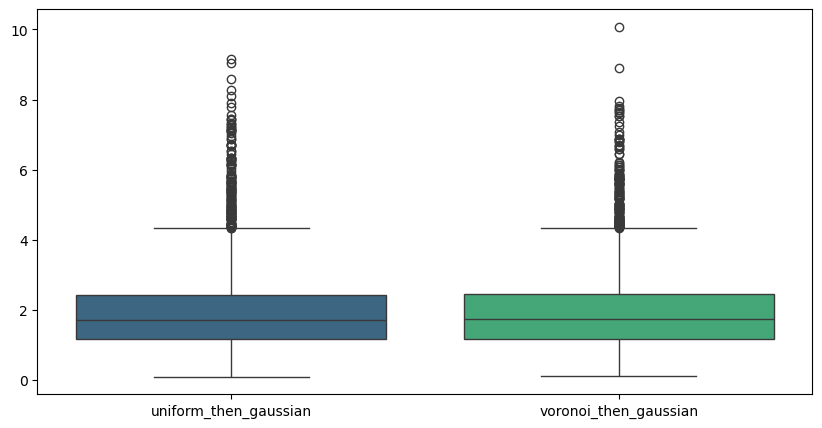

In [35]:
make_boxplot(dfs_test1, samplings, df_key="rmsd")

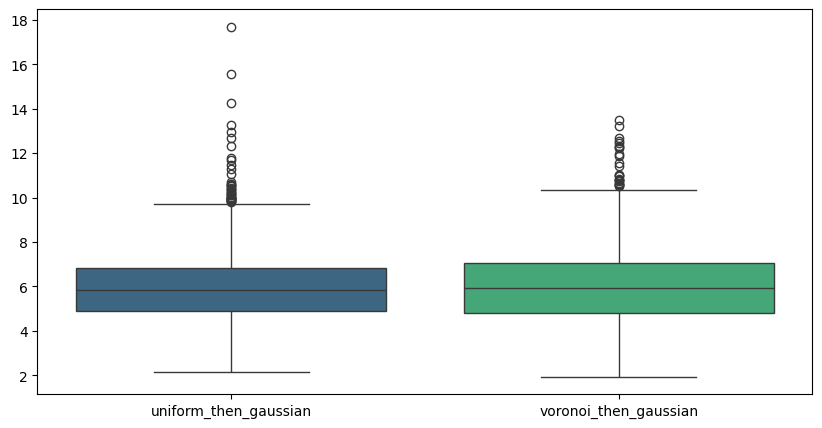

In [36]:
make_boxplot(dfs_test1, samplings, df_key="avg_path_length")

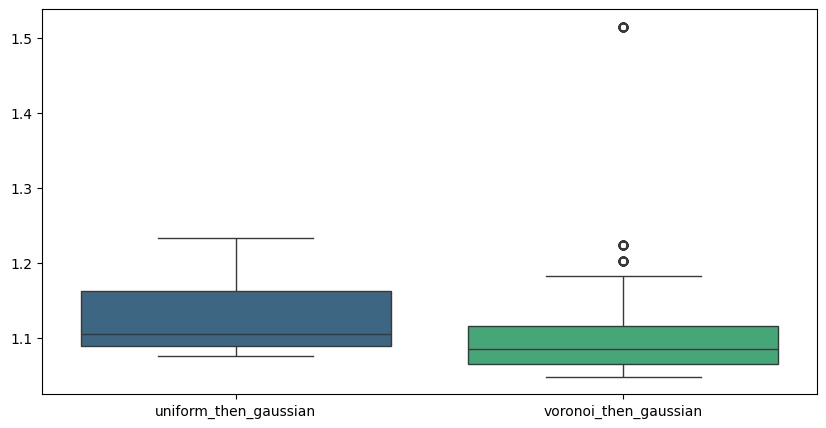

In [37]:
make_boxplot(dfs_test1, samplings, df_key="time_per_sample")

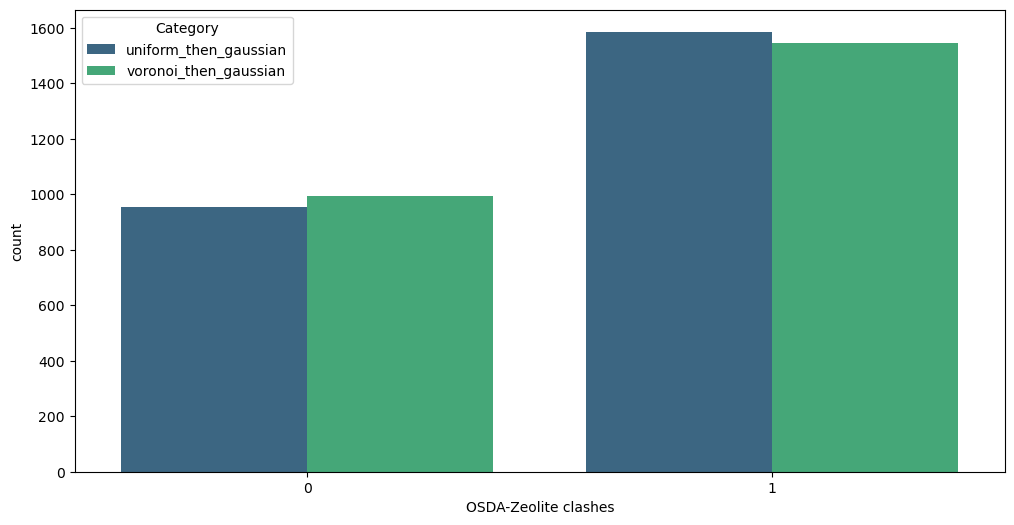

In [38]:
for i in dfs_test1:
    i["is_osda_zeolite_clashed"] = i.apply(lambda x: 1 if x["osda_zeolite_clashes200"] > 0 else 0, axis=1)

make_countplot(dfs_test1, samplings, df_key="is_osda_zeolite_clashed", x_label="OSDA-Zeolite clashes")

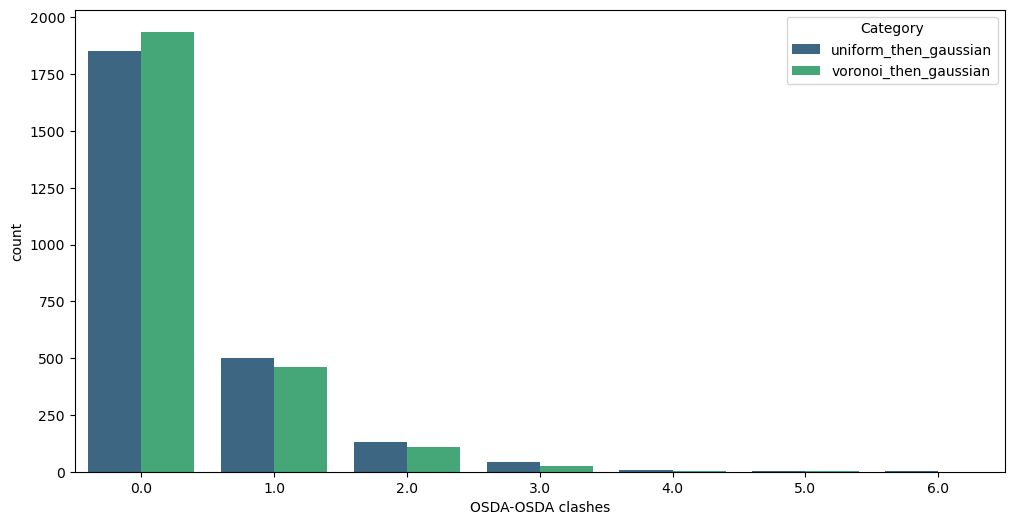

In [39]:
for i in dfs_test1:
    i["is_osda_zeolite_clashed"] = i.apply(lambda x: 1 if x["osda_osda_clashes225"] > 0 else 0, axis=1)

make_countplot(dfs_test1, samplings, df_key="osda_osda_clashes225", x_label="OSDA-OSDA clashes")

0.21220472440944882
0.21771653543307087


/tmp/ipykernel_3283691/3756982569.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['dataframe_id', 'loading'])


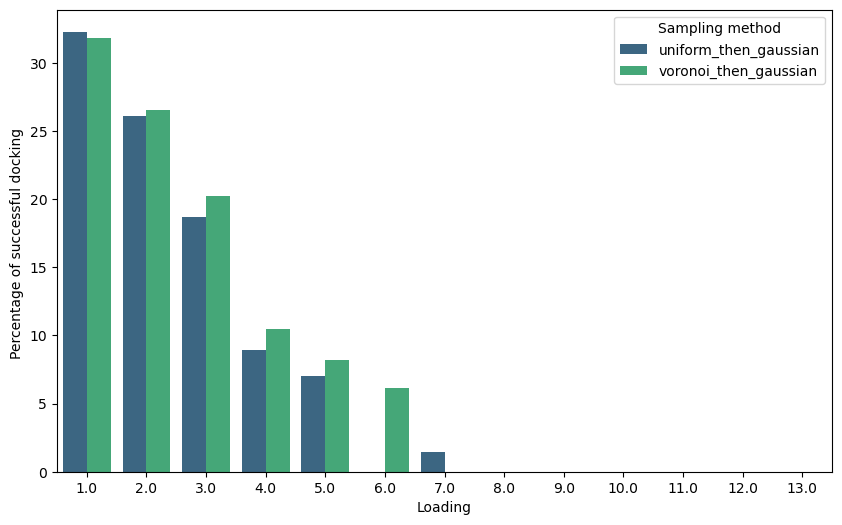

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_success_rate(dfs, samplings):
    for i in dfs:
        i["is_osda_osda_clashed"] = i.apply(lambda x: 1 if x["osda_osda_clashes225"] > 0 else 0, axis=1)
        i["is_osda_zeolite_clashed"] = i.apply(lambda x: 1 if x["osda_zeolite_clashes200"] > 0 else 0, axis=1)
        i["has_high_rmsd"] = i.apply(lambda x: 1 if x["rmsd"] > 2 else 0, axis=1)

        i["success"] = i.apply(lambda x: 1 if (x["is_osda_osda_clashed"] == 0 and x["is_osda_zeolite_clashed"] == 0 and x["has_high_rmsd"] == 0) else 0, axis=1)

        # Filter the dataframe to include only non-clashed datapoints
        # non_clashed_df = i[i['is_osda_zeolite_clashed'] == 0]
        print(i["success"].mean())

    for i, df in enumerate(dfs):
        df['dataframe_id'] = f'{samplings[i]}'
    combined_df = pd.concat(dfs, ignore_index=True)


    # Calculate percentage of non-clashed for each loading and dataframe_id
    percentage_df = (
        combined_df.groupby(['dataframe_id', 'loading'])
        .apply(lambda group: pd.Series({
            'percentage_non_clashed': 100 * (group['success'] == True).mean()
        }))
        .reset_index()
    )

    # Create the percentage plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=percentage_df,
        x='loading',
        y='percentage_non_clashed',
        hue='dataframe_id',
        dodge=True,
        palette="viridis",
    )
    # plt.title("Percentage of successful docking")
    plt.xlabel("Loading")
    plt.ylabel("Percentage of successful docking ")
    plt.legend(title="Sampling method")
    plt.show()

plot_success_rate(dfs_test1, samplings)

In [64]:
dfs_test2 = eval_for_test_set("test_2")

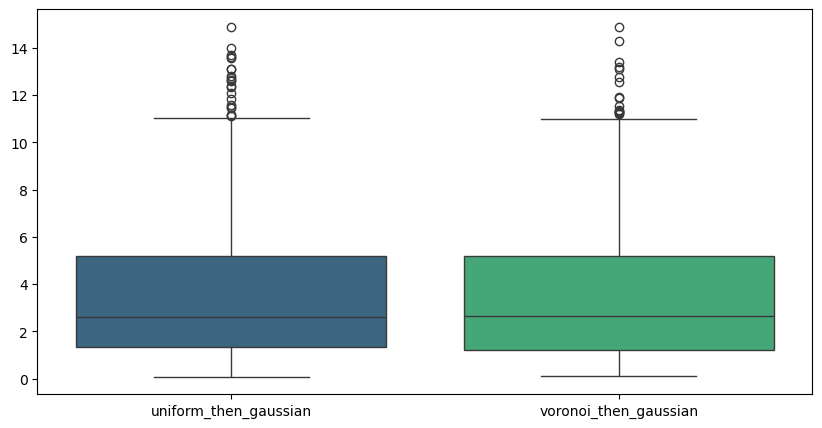

In [65]:
make_boxplot(dfs_test2, samplings, df_key="rmsd")

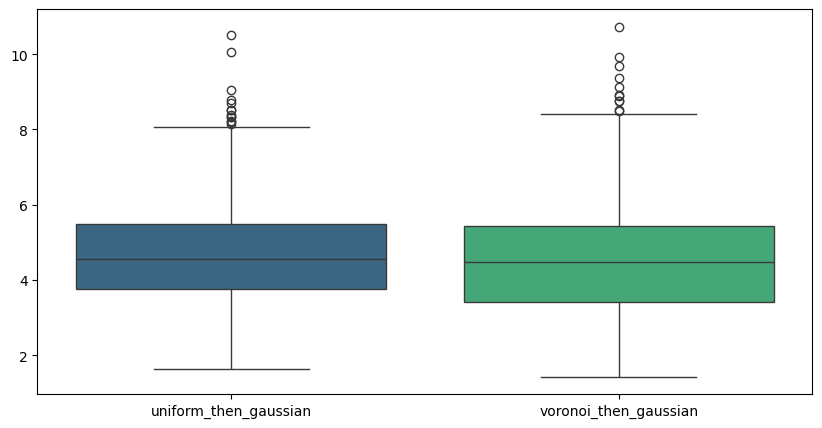

In [66]:
make_boxplot(dfs_test2, samplings, df_key="avg_path_length")

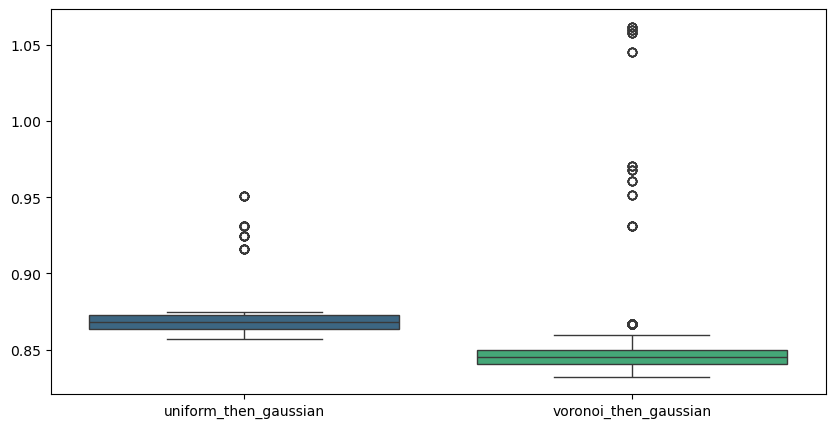

In [67]:
make_boxplot(dfs_test2, samplings, df_key="time_per_sample")

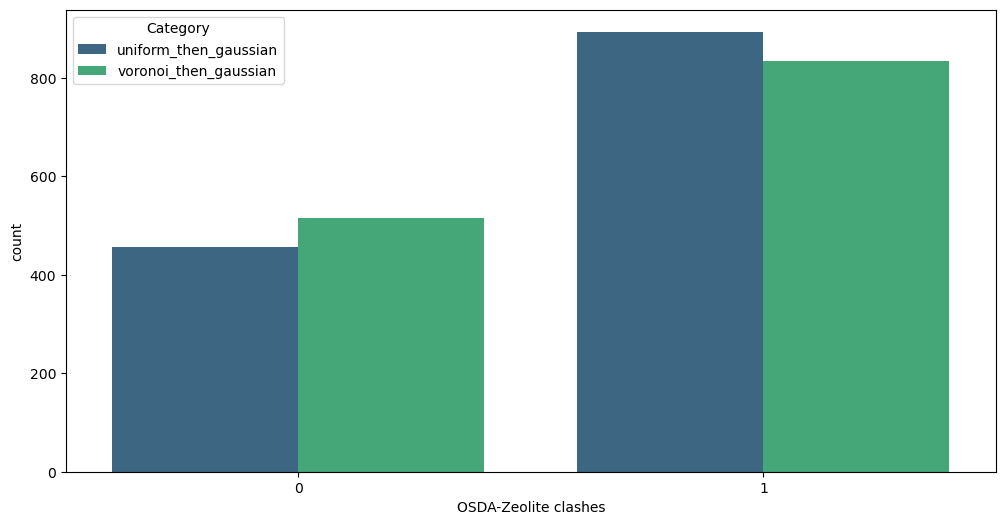

In [68]:
for i in dfs_test2:
    i["is_osda_zeolite_clashed"] = i.apply(lambda x: 1 if x["osda_zeolite_clashes200"] > 0 else 0, axis=1)

make_countplot(dfs_test2, samplings, df_key="is_osda_zeolite_clashed", x_label="OSDA-Zeolite clashes")

0.10740740740740741
0.14148148148148149


/tmp/ipykernel_3283691/3756982569.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['dataframe_id', 'loading'])


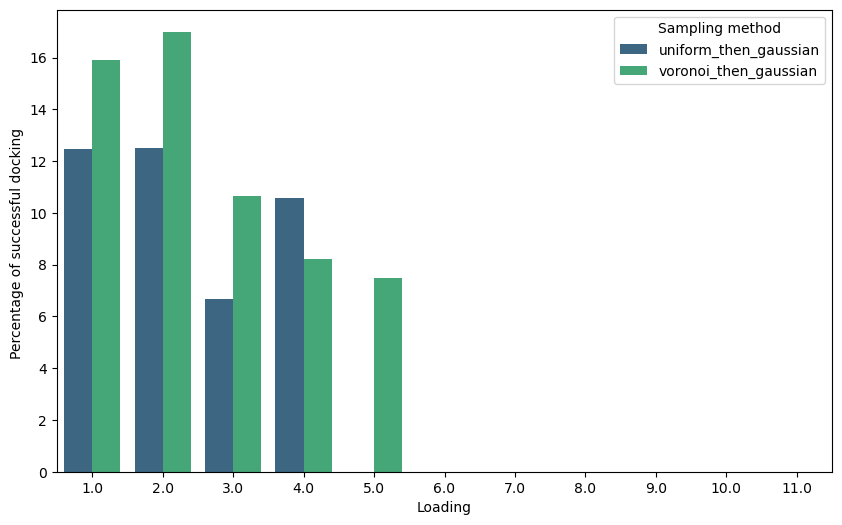

In [69]:
plot_success_rate(dfs_test2, samplings)

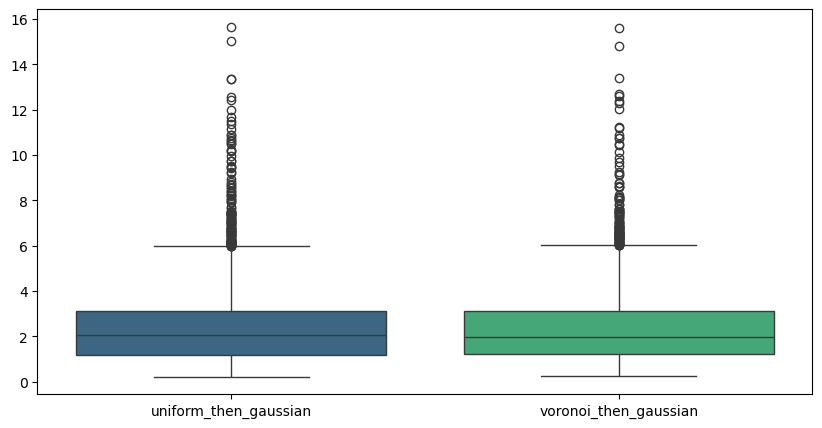

In [70]:
dfs_test3 = eval_for_test_set("test_3")
make_boxplot(dfs_test3, samplings, df_key="rmsd")

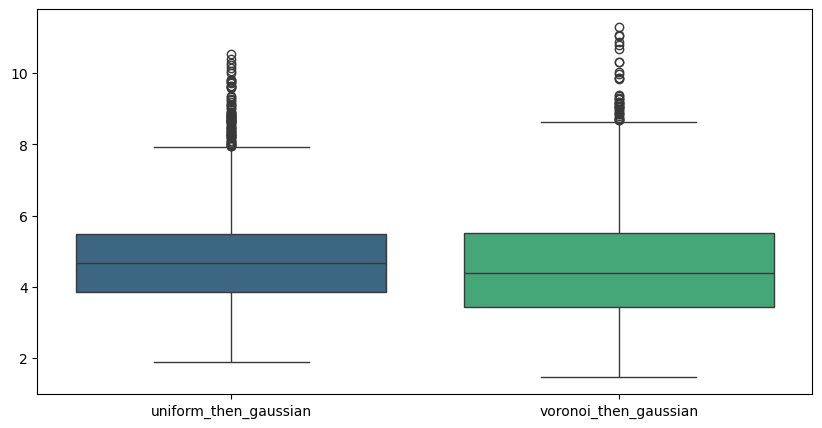

In [71]:
make_boxplot(dfs_test3, samplings, df_key="avg_path_length")

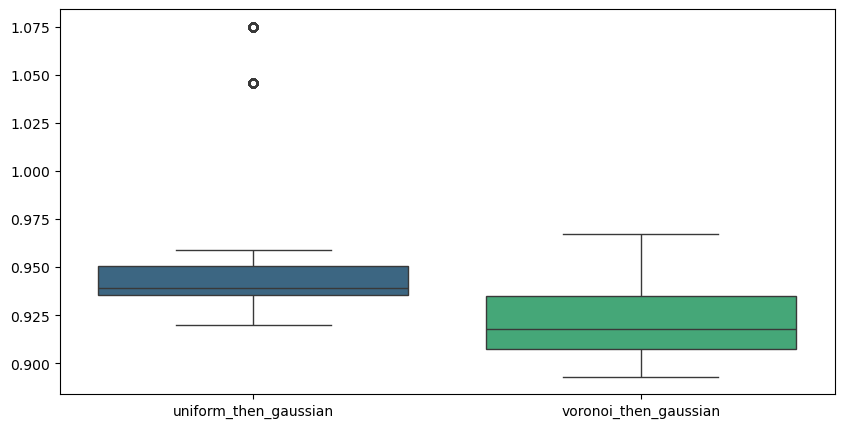

In [72]:
make_boxplot(dfs_test3, samplings, df_key="time_per_sample")

0.0775
0.103125


/tmp/ipykernel_3283691/3756982569.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['dataframe_id', 'loading'])


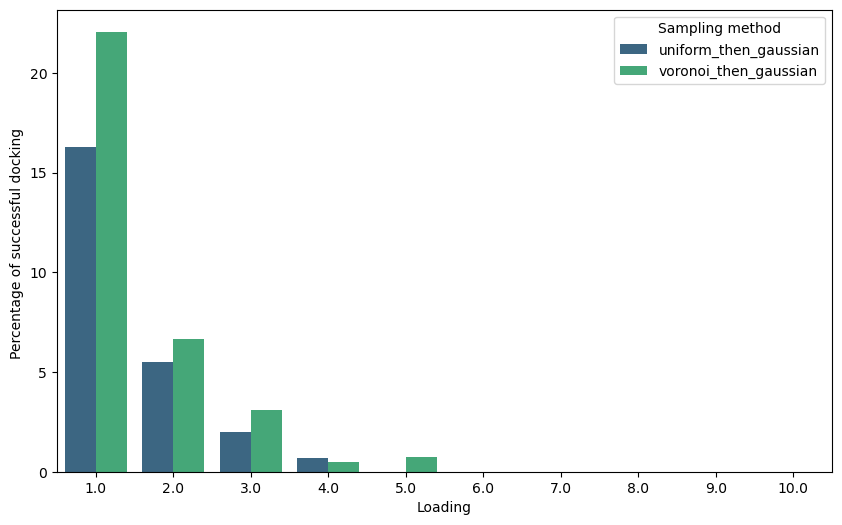

In [73]:
plot_success_rate(dfs_test3, samplings)

In [74]:
# todo: top N - evaluation